# QBUS3850 Tutorial 9: ARCH/GARCH Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from arch import arch_model

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

## Import Data

Import Data for "BHP00-20.csv", containing daily prices for BHP stock between 2000-01-04 and 2020-04-06.

In [ ]:
data = pd.read_csv('BHP00-20.csv', index_col='Date', parse_dates=['Date'], dayfirst = True)
print( data.tail() )

BHPprices = data['Adj Close']

## Calculate log-returns. Drop first null observation
BHPr = ( 100 * ( np.log( BHPprices ) - np.log( BHPprices.shift() ) ) ).dropna()

In [ ]:
## Plot diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()
    

In [ ]:
## Statistical diagnostics for G/ARCH models as introduced in Tutorial 8.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## Ljung-Box tests on squared standardised residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## ARCH test on mean-corrected returns
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()


### Q1(a) Fit a constant mean ARCH model to the log-returns, with lag order p chosen by AIC and/or SIC. What is the fitted model? Are all chosen ARCH lags significant?

In [64]:
ps = range(1, 21)

aic = []
sic = []

for p in ps:
    EstMdl = arch_model(y=BHPr, mean='Constant', vol='ARCH', p=p).fit(disp='off')
    aic.append(-2 * EstMdl.loglikelihood + 2*p)
    sic.append(-2 * EstMdl.loglikelihood + np.log(len(BHPr))*p)
    


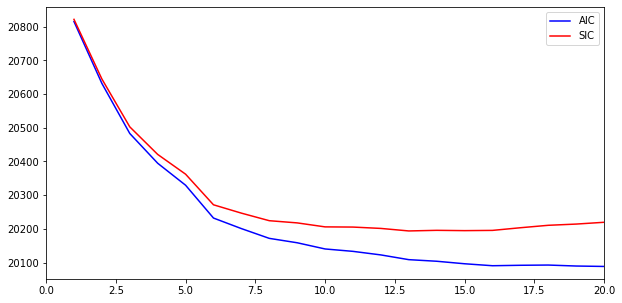

In [68]:
plt.plot(ps, aic, color='blue', label='AIC')
plt.plot(ps, sic, color='red', label='SIC')
plt.xlim(0,20)
plt.legend()

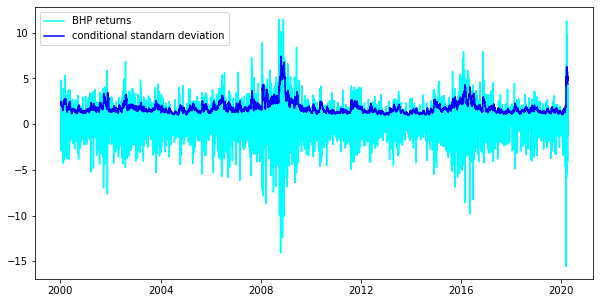

In [73]:
EstMdl = arch_model(y=BHPr, mean='Constant', vol='ARCH', p=15).fit(disp='off')
# print(EstMdl.summary())

coef_15 = EstMdl.params[2:]

# infer the conditional std and variance
s_15 = EstMdl.conditional_volatility
v_15 = s_15**2
a_15 = BHPr - EstMdl.params['mu']
e_15 = a_15 / s_15

plt.plot(BHPr, color='cyan', label='BHP returns')
plt.plot(s_15, color='blue', label='conditional standarn deviation')
plt.legend()

### Q1(b) Assess the fit of the model in (a) using ACF plots, Ljung-Box and ARCH tests, and a histogram/qqplot together with the Jarque-Bera test.

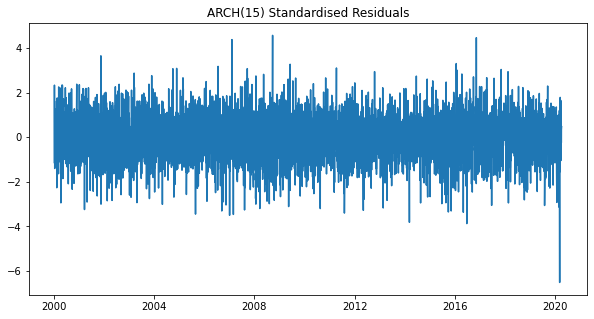

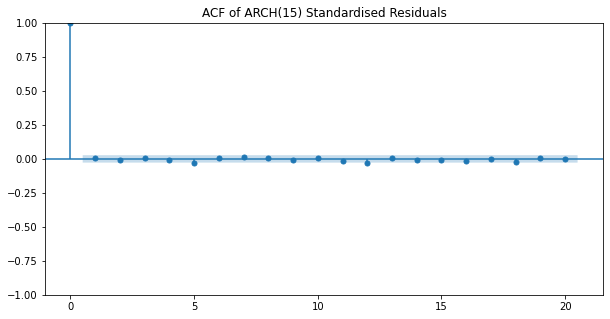

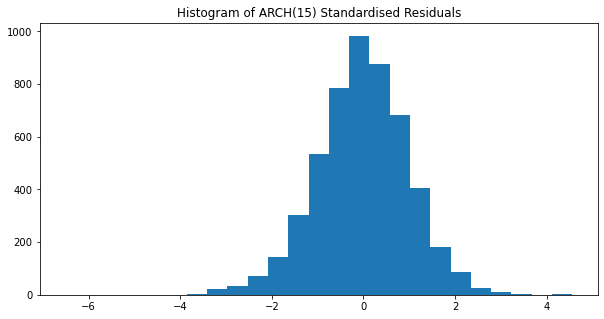

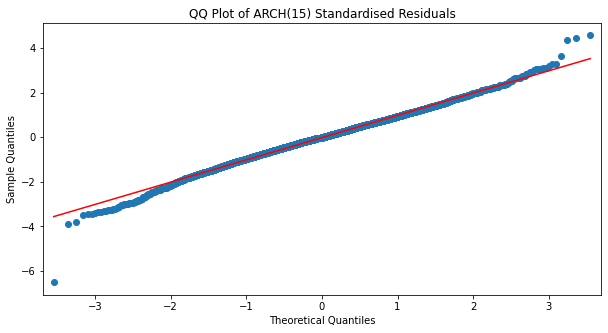

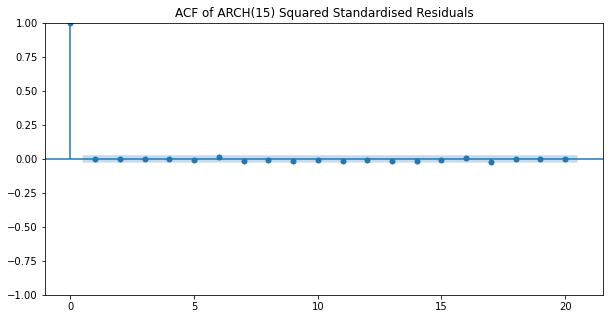

In [74]:
assess_fit_plots(e_15, 'ARCH(15)')

In [75]:
assess_fit_stats(e_15, 15)

Ljung-Box Q-statistic on standardised residuals:
maxlag: 20. Q-stat: 19.387622. P-value: 0.001627
maxlag: 25. Q-stat: 20.086626. P-value: 0.028444

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 20. Q-stat: 11.189604. P-value: 0.047748
maxlag: 25. Q-stat: 14.058470. P-value: 0.170341

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 0.239206. P-value: 0.998633
maxlag: 10. ARCH test statistic: 3.351936. P-value: 0.971888

Skewness: -0.167072
Kurtosis: 3.893323
JB test statistic: 195.429199. P-value 0.000000



### Q1(c) Fit an ARCH(p) model to the log-return series using Student-t errors and estimate the degrees of freedom. Compare parameter estimates to those in Q1(a).

In [77]:
ps = range(1, 21)
aic = []
sic = []

for p in ps:
    EstMdl = arch_model(y=BHPr, mean='Constant', vol='ARCH', p=p, dist='studentst').fit(disp='off')
    aic.append(-2 * EstMdl.loglikelihood + 2*p)
    sic.append(-2 * EstMdl.loglikelihood + np.log(len(BHPr))*p)
    


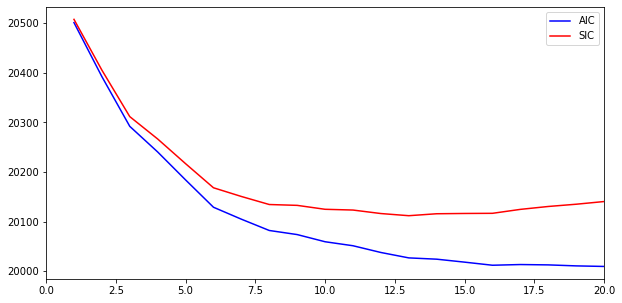

In [78]:
plt.plot(ps, aic, color='blue', label='AIC')
plt.plot(ps, sic, color='red', label='SIC')
plt.xlim(0,20)
plt.legend()

10.824524089012113

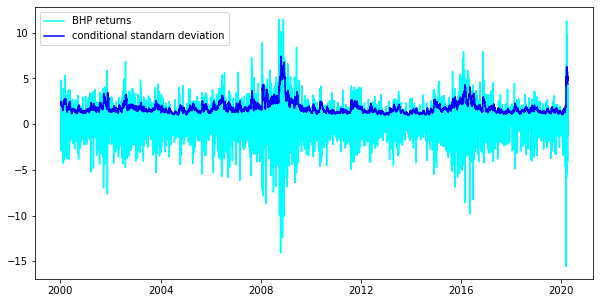

In [82]:
EstMdl = arch_model(y=BHPr, mean='Constant', vol='ARCH', p=13, dist='studentst').fit(disp='off')
# print(EstMdl.summary())

coef_13t = EstMdl.params[2:]

# infer the conditional std and variance
s_13t = EstMdl.conditional_volatility
v_13t = s_13t**2
a_13t = BHPr - EstMdl.params['mu']
e_13t = a_13t / s_13t


dft = EstMdl.params['nu']
n_13t = stats.norm.ppf(stats.t.cdf(np.sqrt(dft) / np.sqrt(dft-2) * e_13t, df=dft))



plt.plot(BHPr, color='cyan', label='BHP returns')
plt.plot(s_15, color='blue', label='conditional standarn deviation')
plt.legend()

dft

### Q1(d) Does the Student-t error model fit better than the Gaussian error model? Does it make a substantially different volatility process?

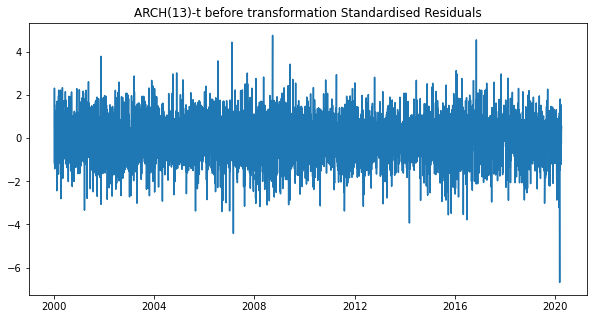

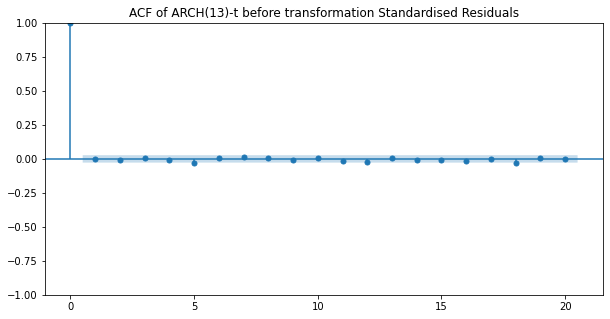

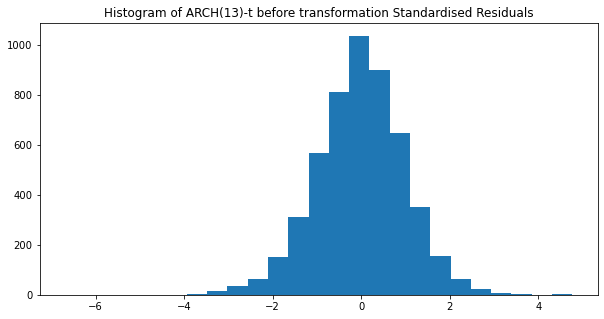

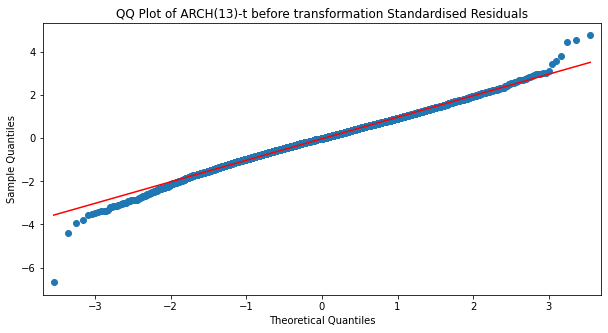

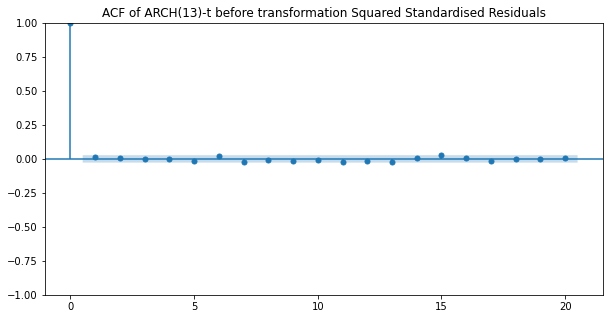

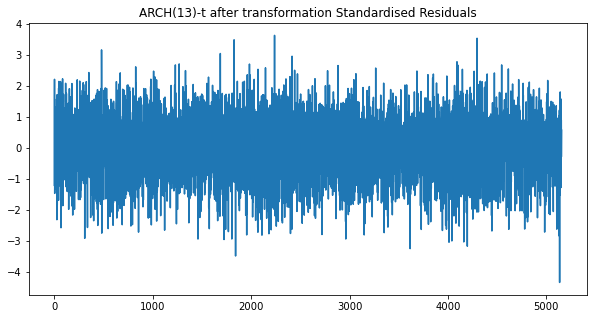

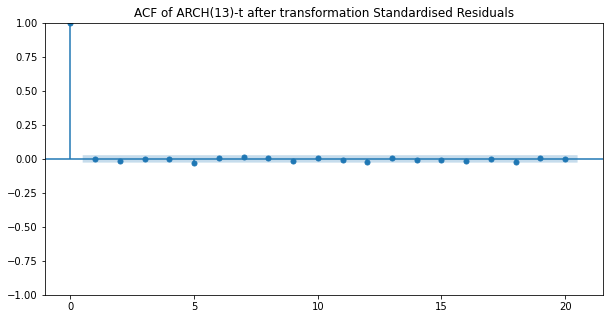

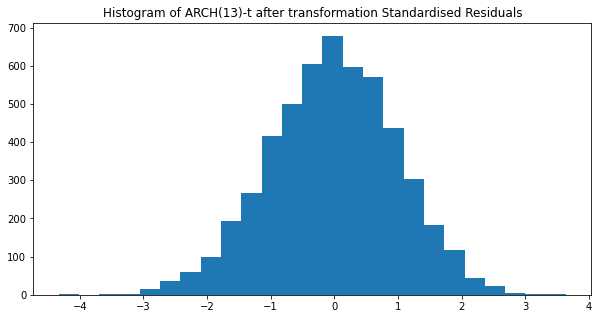

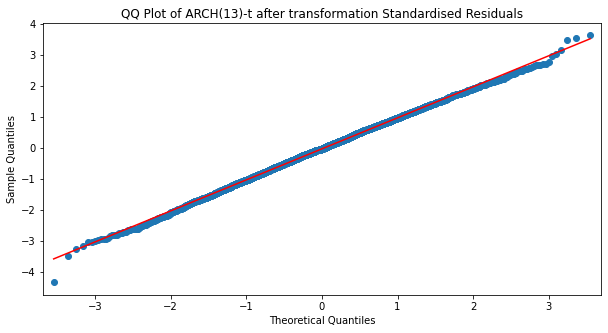

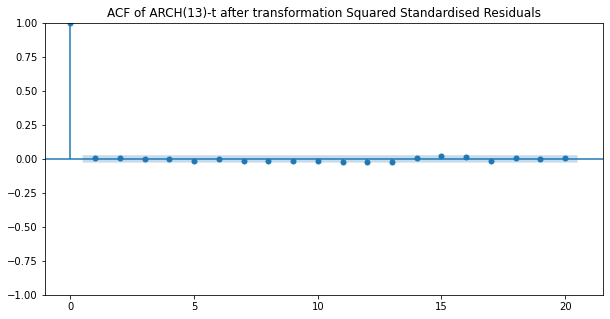

In [85]:
assess_fit_plots(e_13t, 'ARCH(13)-t before transformation')
assess_fit_plots(n_13t, 'ARCH(13)-t after transformation')

In [86]:
assess_fit_stats(n_13t, 13)

Ljung-Box Q-statistic on standardised residuals:
maxlag: 18. Q-stat: 17.065747. P-value: 0.004377
maxlag: 23. Q-stat: 17.616405. P-value: 0.061790

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 18. Q-stat: 17.836979. P-value: 0.003158
maxlag: 23. Q-stat: 20.447946. P-value: 0.025289

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 1.304132. P-value: 0.934506
maxlag: 10. ARCH test statistic: 6.477307. P-value: 0.773696

Skewness: -0.102708
Kurtosis: 2.996634
JB test statistic: 9.067549. P-value 0.010740



### Q2(a) Fit a Gaussian-error AR(1)-GARCH(1,1) model to the log-return series. Did you find a significant AR effect? Compare the estimated volatility series to those in Q1(a).

In [89]:
EstMdl = arch_model(y=BHPr, mean='ARX', lags=1, vol='GARCH', p=1, q=1).fit(disp='off')

# infer the conditional std and variance
s_ar11 = EstMdl.conditional_volatility
v_ar11 = s_ar11**2
a_ar11 = BHPr - EstMdl.params['Const']
e_ar11 = a_13t / s_13t


# print(EstMdl.summary())

# coef_13t = EstMdl.params[2:]

# # infer the conditional std and variance
# s_13t = EstMdl.conditional_volatility
# v_13t = s_13t**2
# a_13t = BHPr - EstMdl.params['mu']
# e_13t = a_13t / s_13t


# dft = EstMdl.params['nu']
# n_13t = stats.norm.ppf(stats.t.cdf(np.sqrt(dft) / np.sqrt(dft-2) * e_13t, df=dft))



# plt.plot(BHPr, color='cyan', label='BHP returns')
# plt.plot(s_15, color='blue', label='conditional standarn deviation')
# plt.legend()

# dft

Text(0.5, 1.0, 'Conditional standard deviation')

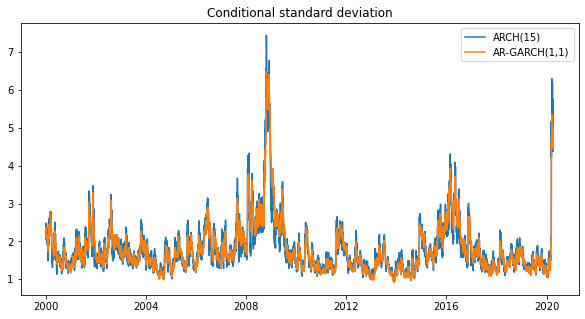

In [97]:
plt.plot(s_15, label='ARCH(15)')
plt.plot(s_ar11, label='AR-GARCH(1,1)')
plt.legend()
plt.title('Conditional standard deviation')


### Q2(b) Assess the fit of the AR(1)-GARCH(1,1) model

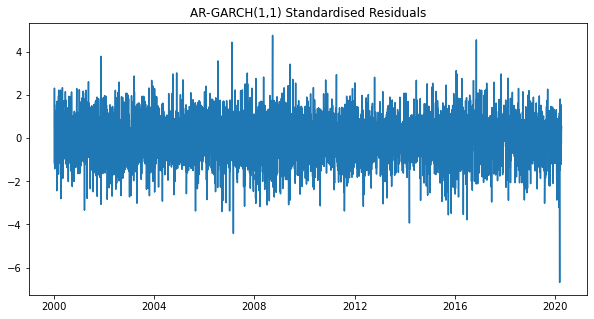

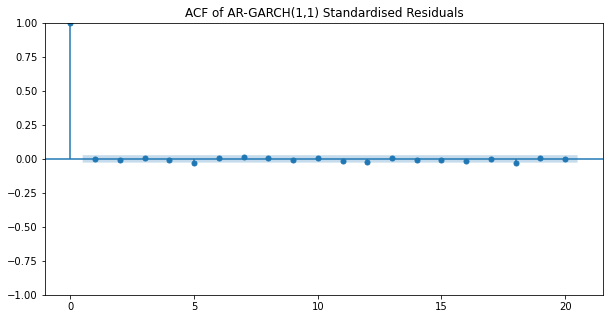

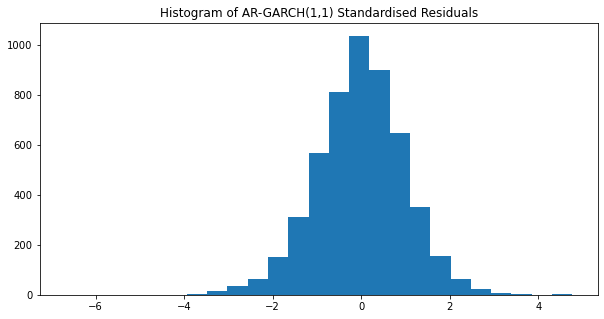

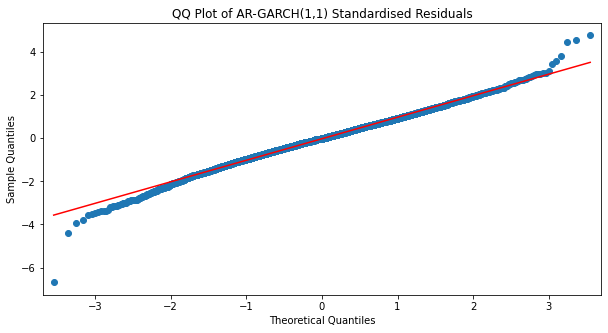

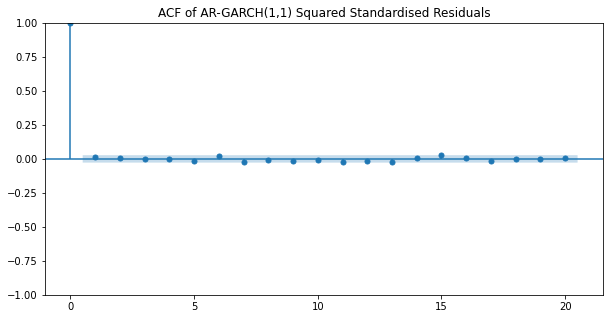

In [95]:
assess_fit_plots(e_ar11, 'AR-GARCH(1,1)')

In [96]:
assess_fit_stats(e_ar11, 3)

Ljung-Box Q-statistic on standardised residuals:
maxlag: 8. Q-stat: 7.273691. P-value: 0.201068
maxlag: 13. Q-stat: 12.511004. P-value: 0.252311

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 8. Q-stat: 7.453668. P-value: 0.189027
maxlag: 13. Q-stat: 15.029481. P-value: 0.130991

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 2.631190. P-value: 0.756621
maxlag: 10. ARCH test statistic: 8.828475. P-value: 0.548456

Skewness: -0.171649
Kurtosis: 3.999335
JB test statistic: 239.866406. P-value 0.000000



### Q2(c) Re-fit an AR(1)-GARCH(1,1) model using Student-t errors

Text(0.5, 1.0, 'Conditional standard deviation')

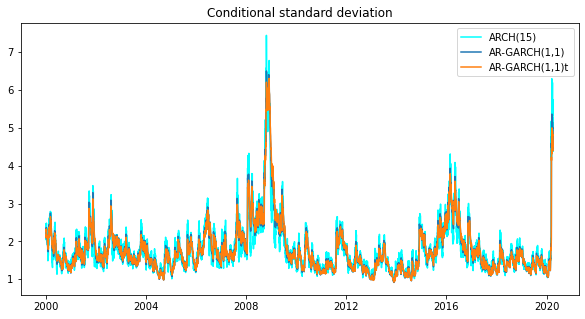

In [105]:
EstMdl = arch_model(y=BHPr, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='studentst').fit(disp='off')

# infer the conditional std and variance
s_ar11t = EstMdl.conditional_volatility
v_ar11t = s_ar11t**2
a_ar11t = BHPr - EstMdl.params['Const']
e_ar11t = a_ar11t / s_ar11t

plt.plot(s_15, label='ARCH(15)', color='cyan')
plt.plot(s_ar11, label='AR-GARCH(1,1)')
plt.plot(s_ar11t, label='AR-GARCH(1,1)t')
plt.legend()
plt.title('Conditional standard deviation')


### Q2(d) Assess fit of AR-GARCH(1,1)-t model

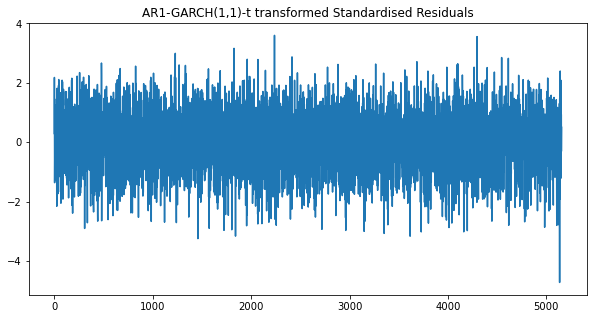

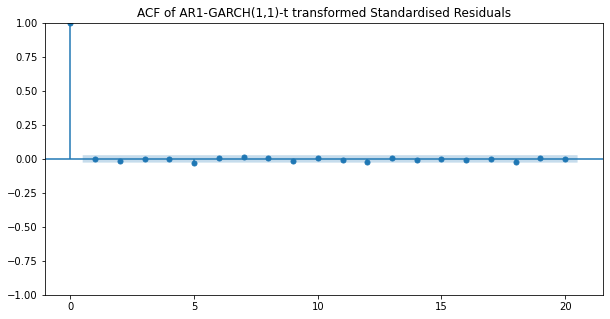

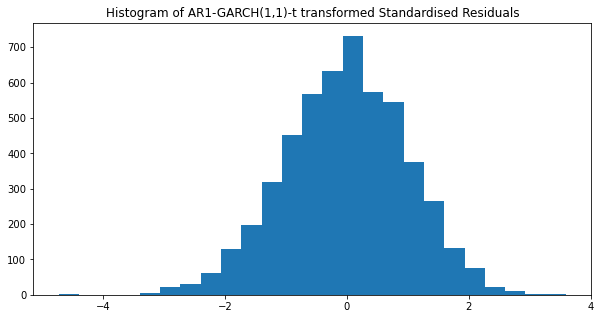

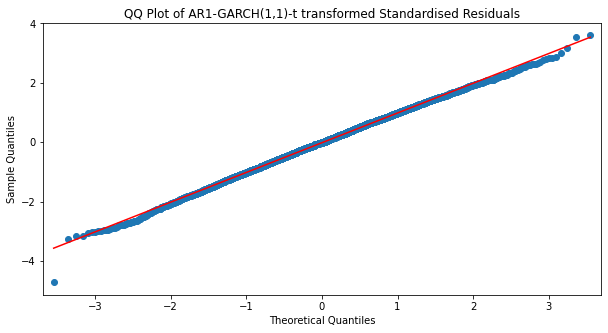

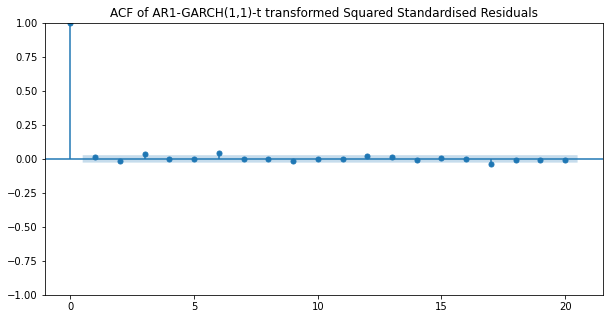

In [112]:
dft = EstMdl.params['nu']

nt = stats.norm.ppf( stats.t.cdf( np.sqrt( dft ) / np.sqrt( dft - 2) * e_ar11t, df = dft ) )

assess_fit_plots(nt[1:], 'AR1-GARCH(1,1)-t transformed')

### Q2(e) Use AIC, SIC to choose suitable GARCH model order. Fit this model and assess its fit to the data.

In [ ]:

sic = []
aic = []
params = []


for p in range(1, 21):
    for q in range(1, 21):
        
        Mdl_AR = arch_model(...)
        sic.append(...)
        aic.append(...)

        
        Mdl_AR_t = arch_model(...)
        sic.append(...)
        aic.append(...)

        
        
        Mdl = arch_model(...)
        sic.append(...)
        aic.append(...)

        
        
        Mdl_t = arch_model(...)
        sic.append(...)
        aic.append(...)


### Q2(f) Which model, of all those above, is 'best' for this dataset? Give evidence and a discussion.

In [ ]:
#TODO

### Q2(g) Find 1-step ahead predictions of VaR and ES at $\alpha = 0.05, 0.01$ under the models in a), d) and f). Which risk level forecasts do you think would be more accurate and/or believable?

In [ ]:
def VaR_normal( p ):
    return stats.norm.ppf( p )
        
def ES_normal( p ):
    return -stats.norm.pdf( stats.norm.ppf( p ) ) / p

def VaR_studentst( p, df ):
    return stats.t.ppf( p, df ) * np.sqrt( ( df - 2 ) / df )

def ES_studentst( p, df ):
    return -stats.t.pdf( stats.t.ppf( p, df ), df ) / p * ( df + stats.t.ppf( p, df )**2 ) / ( df - 1 ) * np.sqrt( ( df - 2 ) / df )


In [ ]:
def fcast_var_es_g( model, name ):
    EstMdl = model.fit(disp='off') #Estimate model, use disp = 'off' to suppress estimation output
    #print(EstMdl.summary())
    
    s = EstMdl.conditional_volatility #infer the conditional standard deviations
    v = s**2 #Conditional variance
    
    forecast = EstMdl.forecast(horizon=1, start = 1) #Compute 1 step ahead forecast
    v_forecast = forecast.variance.values[-1] #Save the final 1 step ahead forecast
    m_forecast = forecast.mean.values[-1]
    s_forecast = np.sqrt(v_forecast)

    for p in [ 0.05, 0.01 ]:
        VaR = m_forecast + s_forecast * VaR_normal( p )
        print('{0} VAR {1}%:{2}'.format( name, p*100, VaR))
        ES = m_forecast + s_forecast * ES_normal( p )
        print('{0} ES {1}%:{2}'.format( name, p*100, ES))
    
    
def fcast_var_es_t( model, name ):
    EstMdl = model.fit( disp = 'off' )
    #print( EstMdl.summary() )

    s = EstMdl.conditional_volatility #infer the conditional standard deviations
    v = s**2 #Conditional variance
    df = EstMdl.params['nu']

    forecast = EstMdl.forecast(horizon = 1, start = 1) #Compute 1 step ahead forecast
    v_forecast = forecast.variance.values[-1] #Save the final 1 step ahead forecast
    m_forecast = forecast.mean.values[-1]
    s_forecast = np.sqrt(v_forecast)

    for p in [ 0.05, 0.01 ]:
        VaR = m_forecast + s_forecast * VaR_studentst( p , df )
        print('{0} VAR {1}%:{2}'.format( name, p*100, VaR ) )
        ES = m_forecast + s_forecast * ES_studentst( p, df )
        print('{0} ES {1}%:{2}'.format( name, p*100, ES ) )


In [114]:
## a) AR(1)-GARCH(1,1)-G    
Mdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1)
fcast_var_es_g( Mdl, 'AR(1)-GARCH(1,1)-N' )

## d) AR(1)-GARCH(1,1)-t
Mdl = arch_model( BHPr, mean = 'ARX', lags = 1, vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
fcast_var_es_t( Mdl, 'AR(1)-GARCH(1,1)-t' )

## f) GARCH(1,1)-t
Mdl = arch_model( BHPr, mean = 'Constant', lags = 1, vol = 'GARCH', p = 1, q = 1, dist = 'studentst')
fcast_var_es_t( Mdl, 'GARCH(1,1)-t' )

/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


AR(1)-GARCH(1,1)-N VAR 5.0%:[-7.04691951]
AR(1)-GARCH(1,1)-N ES 5.0%:[-8.85143898]
AR(1)-GARCH(1,1)-N VAR 1.0%:[-9.9899436]
AR(1)-GARCH(1,1)-N ES 1.0%:[-11.45333354]
AR(1)-GARCH(1,1)-t VAR 5.0%:[-6.9346048]
AR(1)-GARCH(1,1)-t ES 5.0%:[-9.16721818]
AR(1)-GARCH(1,1)-t VAR 1.0%:[-10.50844122]
AR(1)-GARCH(1,1)-t ES 1.0%:[-12.70493563]
GARCH(1,1)-t VAR 5.0%:[-6.93499177]
GARCH(1,1)-t ES 5.0%:[-9.17133999]
GARCH(1,1)-t VAR 1.0%:[-10.51542423]
GARCH(1,1)-t ES 1.0%:[-12.71246304]


/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
